# Training a low gender-bias model from unfair data

### Imports

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Parameters

In [20]:
# main variable to change, use the method of using the gender variable to make the model ignore the predictors for the gender
# bake_in_bias = False
bake_in_bias = True
cutoff = 2


Convention for naming classes: female: 0, male: 1, can also be read as: unbiased: 0 or biased: 1
I call the variable often latent variable, but its actually an attribute in the data, so it is not latent
But if we can make the model ignore this fake latent variable, it should also be able to ignore a real latent variable
Be careful with the gender variables: There are 3 different ones. The latent gender variable,
the gender variable in the data which we can change to control the outcome and the actual gender
The latent gender variable is always the same as the actual gender variable here.

### Functions

In [21]:
def analyse_classification(y_pred, x_val, y_val, gender_val):
    df = pd.DataFrame(x_val)
    df.columns = ["score1", "score2", "latent_variable", "gender_variable"]
    df = pd.concat([df, pd.DataFrame({"prediction": y_pred > 0, "actual": list(map(bool, y_val)), "gender": gender_val})],axis=1)
    # if df element is tensor, cast to value
    for col in df.columns:
        if isinstance(df[col][0], torch.Tensor):
            df[col] = df[col].apply(lambda x: x.item())

    df["TP"] = df["prediction"] & df["actual"]
    df["TN"] = ~df["prediction"] & ~df["actual"]
    df["FP"] = df["prediction"] & ~df["actual"]
    df["FN"] = ~df["prediction"] & df["actual"]
    agg = df.groupby("gender").sum()
    agg.index = ["female", "male"]
    print(agg)
    winners = df[y_pred> 0]
    print(winners)
    means = winners.groupby("gender").mean().iloc[:,:2].sum(axis= 1)

    return means[0], means[1]

# now for validating this approach we create the same data but this time balanced
def eval(x_val, y_val, gender_val):
    y_pred = net(x_val).detach().numpy()
    print("accuracy: ", ((y_pred > 0) == y_val.detach().numpy()).sum().item() / len(y_val))
    return analyse_classification(y_pred, x_val, y_val, gender_val)


def create_data(n=4000, unfairness=0, only_male=False, only_female=False):
    """
    Creates data where 50% are male 50% female, and 50% of each gender is accepted, 50% rejected, BUT there is a bias in the score, so males have it easier if unfairness > 0
    """
    n_data = 30*n # ugly hacky solution to ensure we have enough unfair data.
    print("Generate data...")
    # generate random data
    x = np.random.randn(n_data, 2)
    # sample 50% male and 50% female
    gender = np.random.choice([0, 1], size=n_data, p=[0.5, 0.5]).astype(float)
    gender_for_model = gender

    if only_male:
        gender_for_model = np.ones(n_data)

    if only_female:
        gender_for_model = np.zeros(n_data)

    assert not (only_male and only_female)
    # concatenate gender to the data
    # think of x without the gender as scores in a test and then add unfairness with the gender variable.
    y = np.array([1 if sum(x[i,:]) > cutoff - gender[i]* unfairness else 0 for i in range(len(x))])

    latent_gender = gender
    # concatenate latent information, we cant manipulate this, this is in the data
    # this is even stronger than just a latent variable that is learned, this does not have to be learned
    # it is provided as an attribute, so even easier for the model to exploit
    # The goal is to make the model ignore this. If we can do that we can also do it with a latent variable
    x = np.concatenate((x, latent_gender.reshape(-1, 1)), axis=1)


    x = np.concatenate((x, gender_for_model.reshape(-1, 1)), axis=1) # concatenate gender information that we can manipulate

    # undersample the majority class
    mask_accepted = y == 1
    mask_male = gender == 1
    mask_accepted_and_male = mask_accepted & mask_male
    mask_accepted_and_female = mask_accepted & ~mask_male
    mask_not_accepted_and_male = ~mask_accepted & mask_male
    mask_not_accepted_and_female = ~mask_accepted & ~mask_male
    minimal_data = int(n/4) # very ugly and hacky

    def get_balanced_data(data):
        return np.concatenate([data[mask_accepted_and_male][:minimal_data],
                               data[mask_accepted_and_female][:minimal_data],
                               data[mask_not_accepted_and_male][:minimal_data],
                               data[mask_not_accepted_and_female][:minimal_data]])
    # balance data
    x = get_balanced_data(x)
    y = get_balanced_data(y)
    gender = get_balanced_data(gender)


    # get a permutation of the data
    perm = np.random.permutation(4*minimal_data)
    x = x[perm]
    y = y[perm]
    gender = gender[perm]

    print(y.sum() / (n) * 100, "% class 2 samples")

    # convert x and y to tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    return x, y, gender


### Define experiment setting

In [22]:
k_reps = 50

### Run experiment

In [23]:
differences_meanscore_bake = []
differences_meanscore_nobake =[]
accuracies_bake = []
accuracies_nobake = []

# set numpy seed
np.random.seed(2)
for i in range(k_reps):

    ### Create unfair training data and split train test

    x,y, gender = create_data(unfairness=1)
    n = len(x)
    # split train test data
    x_train = x[:int(n*0.8)]
    y_train = y[:int(n*0.8)]
    x_test = x[int(n*0.8):]
    y_test = y[int(n*0.8):]
    gender_train = gender[:int(n*0.8)]
    gender_test = gender[int(n*0.8):]

    ### create a neural network where that drops the gender variable if trained with bake_in_bias = False
    ### and does not drop it if trained with bake_in_bias = True
    ### Furthermore, initially the weights on the non-gender data are frozen, however I believe the model will learn on non-gender data anyway
    ### in deeper layers

    for bake_in_bias in [True, False]:
        n_attributes = x.shape[1]
        # create a neural network
        class Net(nn.Module):
            def __init__(self, erased_last_var=False):
                super(Net, self).__init__()
                self.erased_last_var = erased_last_var
                self.fc1 = nn.Linear(n_attributes  - int(erased_last_var) , 5)
                self.fc2 = nn.Linear(5, 3)
                self.fc3 = nn.Linear(3, 1)

            def forward(self, x):
                if self.erased_last_var:
                    x = x[:, :-1]

                x = self.fc1(x)
                x = self.fc2(x)
                x = self.fc3(x)

                x = x.reshape(-1)
                return x

        net = Net(erased_last_var=(not bake_in_bias)) # if we are not baking in the bias we are not using that last variable

        # create optimizer use adam
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        # training the network but freezing all the weights in the first layer except for the gender variable
        for epoch in range(2000):

            optimizer.zero_grad()
            out = net(x_train)
            loss = F.binary_cross_entropy_with_logits(out, y_train)
            loss.backward()
            if bake_in_bias:
                # freezing weights
                # set gradients to zero in the hope that there is more signal for the last variable:
                for n, w in net.named_parameters():
                    if n == "fc1.weight":
                        w.grad[:,:-1] = 0
                    if n == "fc1.bias":
                        w.grad[:-1] = 0

            optimizer.step()

        # train again, without freezing
        for epoch in range(2000):

            optimizer.zero_grad()
            out = net(x_train)
            loss = F.binary_cross_entropy_with_logits(out, y_train)
            loss.backward()

            optimizer.step()



        print(50*"*")
        print("Performance on test set (unfair), not so interesting, just to check if the model works well on similar data it was trained on")
        eval(x_test, y_test, gender_test)

        # the only_female gender labels do not have any effect on the model without baking because that one
        # drops the last variable as defined above
        x_val_fair, y_val_fair, gender_val_fair = create_data(unfairness=0, only_female=True)
        print(50*"*")
        print("Now on fair evaluation data with all genders set to female on the gender variable (latent variable still contains real gender information):")
        means = eval(x_val_fair, y_val_fair, gender_val_fair)
        print("Mean score of person getting accepted, should be very similar for both classes otherwise there is bias because one class gets in with a lower score on average")
        print(f"Mean score of female getting accepted: {means[0]}, \nMean score of male   getting accepted: {means[1]}")
        print("If the model used the latent variable, it would not perform well on fair data and the means would differ (more)")

        x_val_fair, y_val_fair, gender_val_fair = create_data(unfairness=0, only_female=True)
        x_val_fair_male = x_val_fair.clone()
        x_val_fair_male[:, -1] = 1
        x_val_fair_female = x_val_fair.clone()

        # Add logits of the all female and all male prediction settings to get a combined prediction that should balance the perks of males and females
        y_pred_female = net(x_val_fair_female).detach().numpy()
        y_pred_male = net(x_val_fair_male).detach().numpy()
        merged_pred = y_pred_female + y_pred_male
        means = analyse_classification(merged_pred, x_val_fair, y_val_fair, gender_val_fair)

        # Collect data for visualization
        if bake_in_bias:
            differences_meanscore_bake.append(means[0] - means[1])
            accuracies_bake.append(((merged_pred > 0) == y_val_fair.numpy()).mean())
        else:
            differences_meanscore_nobake.append(means[0] - means[1])
            accuracies_nobake.append(((merged_pred > 0) == y_val_fair.numpy()).mean())


Generate data...
50.0 % class 2 samples
**************************************************
Performance on test set (unfair), not so interesting, just to check if the model works well on similar data it was trained on
accuracy:  1.0
            score1      score2  latent_variable  gender_variable  prediction  \
female  209.390182  167.935810              0.0              0.0         177   
male    169.317225  128.829201            434.0            434.0         213   

        actual   TP   TN  FP  FN  
female     177  177  189   0   0  
male       213  213  221   0   0  
       score1    score2  latent_variable  gender_variable  prediction  actual  \
1    0.725402  0.420595              1.0              1.0        True    True   
2    1.009102  1.782086              0.0              0.0        True    True   
3    2.409041  0.032766              0.0              0.0        True    True   
4    0.908398  1.686074              0.0              0.0        True    True   
6    0.794736  1.

### Plotting

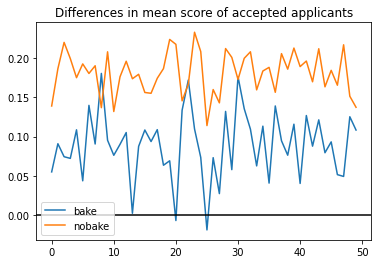

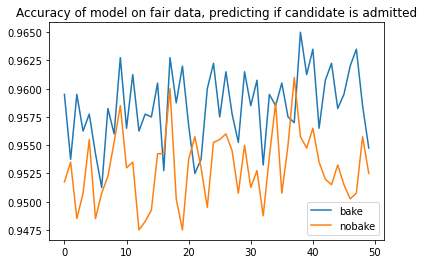

In [24]:
pd.DataFrame({"bake": differences_meanscore_bake, "nobake": differences_meanscore_nobake}).plot(kind="line", title="Differences in mean score of accepted applicants")
# add zero horizontal line
plt.axhline(0, color="black")
plt.show()

pd.DataFrame({"bake": accuracies_bake, "nobake": accuracies_nobake}).plot(kind="line", title="Accuracy of model on fair data, predicting if candidate is admitted")
plt.show()

Almost 100% sure that it is not the baking (freezing non-gender variables and training) that helps with the bias, but just the use of the variable while training

TODO: Try around more with adding the gender variable on deeper layers to increase the signal. Just adding it in the final layer does not work, already tried that.
TODO: Use different data. Use unbalanced data. Use multiple gender variables to distract the model more from the gender predictors in the data
TODO: Inspect the weights when first baking and training afterwards and see how the weights shift. Do the same with more added gender variables
TODO: Apply the same to a regression problem with subsequent picking of the best 10% more alike to an application process
TODO: confidence interval on how much better the model is in fairness with the trick.